In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# import
import warnings
warnings.filterwarnings('ignore')
assets = '/app/assets'
data = '/app/data'

In [4]:
def get_diversity_map(level = 10):
    area_scope_columns = ['Name', 'geometry']
    area_scope = gpd.read_parquet(f'{assets}/area_scope/area_scope.parquet')
    area_scope = area_scope[area_scope_columns]
    area_crs = area_scope.crs

    land_uses = gpd.read_parquet(f'{assets}/land_uses/actual.parquet')
    land_uses = land_uses.to_crs(area_crs)

    unit_key = 'hex_id'
    unit = gpd.read_parquet(f'{data}/set/hex/level_{level}.parquet')
    unit = unit.to_crs(area_crs)

    overlay_unit_area = gpd.overlay(unit, area_scope)
    overlay_unit_landuses = gpd.overlay(unit, land_uses)

    diversity_columns = [unit_key, 'Uso', 'area_predio', 'geometry']
    overlay_unit_landuses = overlay_unit_landuses[diversity_columns]

    overlay_unit_landuses['area_uso'] = overlay_unit_landuses['geometry'].area

    unit_area_uso = overlay_unit_landuses[[unit_key, 'Uso', 'area_uso']].groupby([unit_key, 'Uso']).agg('sum').reset_index()
    unit_area_total = overlay_unit_landuses[[unit_key, 'area_uso']].groupby([unit_key]).agg('sum').reset_index().rename(columns={'area_uso': 'total_uso'})

    unit_area = pd.merge(unit_area_total, unit_area_uso, on=unit_key)

    unit_area['porcion_uso'] = unit_area['area_uso']/unit_area['total_uso']

    unit_area['informacion_uso'] = -1*unit_area['porcion_uso']*np.log2(unit_area['porcion_uso'])
    neg_filter = unit_area['informacion_uso'] < 0.000001
    unit_area.loc[neg_filter, 'informacion_uso'] = 0

    diversity = unit_area[[unit_key, 'informacion_uso']].groupby(unit_key).agg('sum').reset_index().rename(columns={'informacion_uso': 'diversity'})

    gdf_diversity = pd.merge(unit, diversity, on=unit_key)
    gdf_diversity = gpd.GeoDataFrame(gdf_diversity, geometry=gdf_diversity['geometry'])
    gdf_diversity.fillna(0, inplace=True)
    return gdf_diversity

def calculate_total_diversity():
    area_scope_columns = ['Name', 'geometry']
    area_scope = gpd.read_parquet(f'{assets}/area_scope/area_scope.parquet')
    area_scope = area_scope[area_scope_columns]
    area_crs = area_scope.crs

    land_uses = gpd.read_parquet(f'{assets}/land_uses/actual.parquet')
    land_uses = land_uses.to_crs(area_crs)
    land_uses_cols = ['Id', 'Uso', 'area_predio', 'geometry']
    land_uses = land_uses[land_uses_cols]
    
    total_area = land_uses['area_predio'].sum()
    agg_land_uses = land_uses[['Uso', 'area_predio']].groupby('Uso').agg('sum').reset_index()
    agg_land_uses['porcion_uso'] = agg_land_uses['area_predio']/total_area
    agg_land_uses['info_predio'] = -1*agg_land_uses['porcion_uso']*np.log2(agg_land_uses['porcion_uso'])
    return agg_land_uses['info_predio'].sum()

In [5]:
diversity_value = calculate_total_diversity()
diversity_value

3.018693355908966

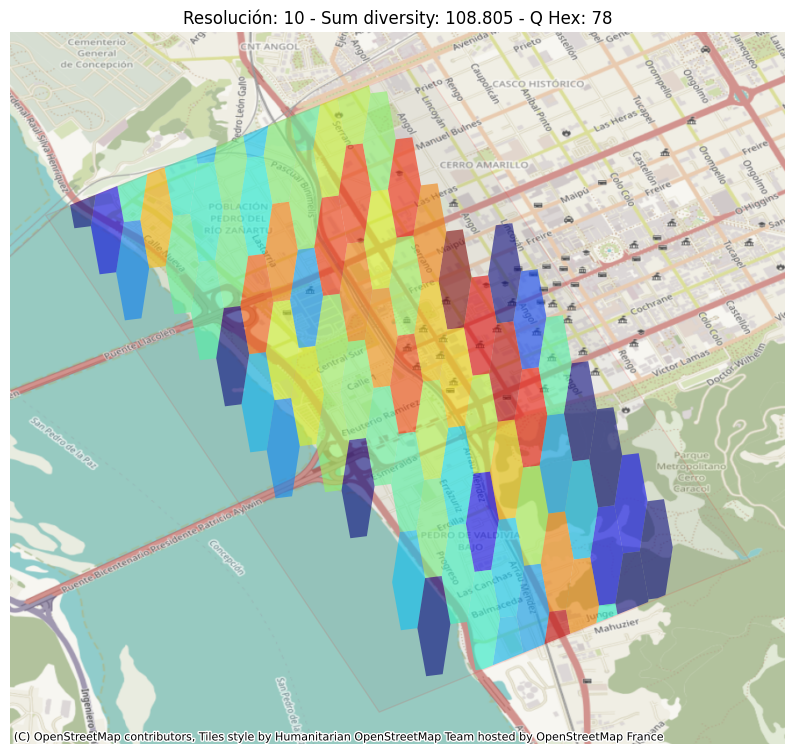

In [20]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import contextily as ctx
import os

filename = 'diversity_map_v1'
save_path = '/app/data'

area_scope = gpd.read_parquet(f'{assets}/area_scope/area_scope.parquet')
area_scope = area_scope.to_crs(4326)


fig, ax = plt.subplots(figsize=(10,10))
levels = [10, 11, 12, 13]
def update(frame):
    ax.clear()  # Limpia el gráfico anterior
    level = levels[frame]
    # print(resolucion)
    try:
        gdf_diversity = get_diversity_map(level)
        gdf_diversity = gdf_diversity.to_crs(4326)

        total_hexs = gdf_diversity.shape[0]
        
        # Asumiendo que overlay_hexs es un GeoDataFrame que quieres plotear
        # gdf_diversity.plot(ax=ax, column='diversity', cmap='jet', vmin=0, vmax=3, alpha=0.6)
        # area_scope.plot(ax=ax, edgecolor='red', alpha=0.1, color='gray')
        total_diversity = gdf_diversity['diversity'].sum()
        cut_gdf_diversity = gpd.overlay(area_scope, gdf_diversity)
        cut_gdf_diversity.plot(ax=ax, column='diversity', cmap='jet', vmin=0, vmax=3, alpha=0.6)
        area_scope.plot(ax=ax, edgecolor='red', alpha=0.1, color='gray')

        # print(gdf_diversity)
        ctx.add_basemap(ax, crs=gdf_diversity.crs)  # Agrega un mapa base; ajusta el proveedor según prefieras
        ax.set_axis_off()  # Opcional: quita los ejes para una visualización más limpia

        plt.savefig(os.path.join(save_path, f'{filename}_{frame}.png'))

        # Establecer título con el número total de hexágonos
        ax.set_title(f"Resolución: {level} - Sum diversity: {total_diversity:.3f} - Q Hex: {total_hexs}")
    except:
        ax.set_title(f"Resolución: {level} - Error")   

# Crear animación
ani = FuncAnimation(fig, update, frames=range(len(levels)), repeat=False)

# Guardar la animación como un gif
ani.save(os.path.join(save_path, f'{filename}.gif'), writer='imagemagick', fps=1)  # Ajusta fps según necesidad


<Axes: >

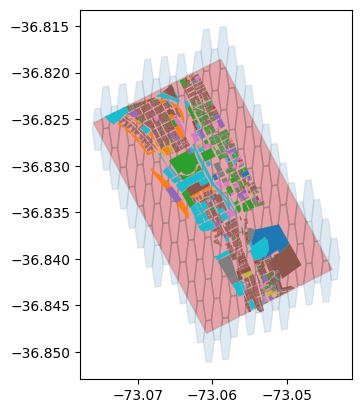

In [34]:
fig, ax = plt.subplots()
unit.plot(ax=ax, alpha=0.15, edgecolor='gray')
# area_scope.plot(ax=ax, edgecolor='black', color='red', alpha=0.3)
overlay_unit_area.plot(ax=ax, edgecolor='gray', color='red', alpha=0.3)
land_uses.plot(ax=ax, column='Uso')

<Axes: >

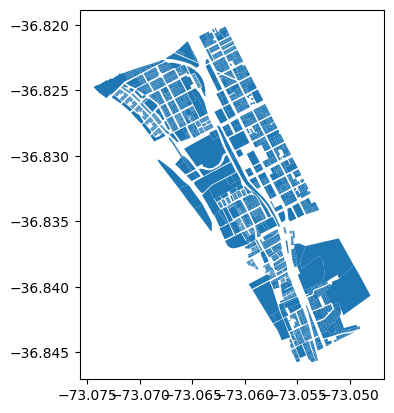

In [66]:
land_uses = gpd.read_parquet(f'./assets/land_uses/actual.parquet')
land_uses = land_uses.to_crs(4326)
land_uses.shape
land_uses.plot()

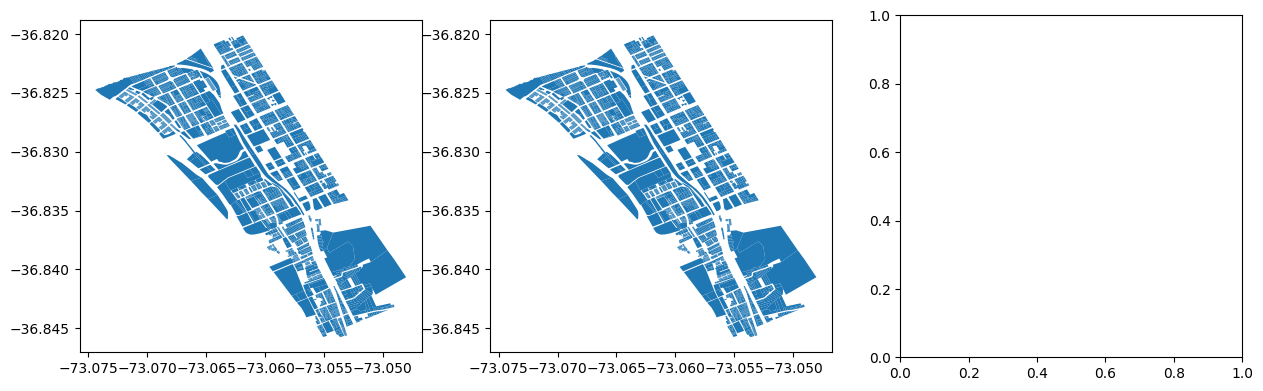

In [74]:
import geopandas as gpd
from shapely import wkt
import pandas as pd
import matplotlib.pyplot as plt
import requests
r = requests.get('http://localhost:8000/api/landuse/')
gdf = gpd.GeoDataFrame(r.json())
gdf[['eps', 'geo']] = gdf['geometry'].str.split(";", expand=True)
gdf['geo'] = gdf['geo'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geo')
fig,ax = plt.subplots(1,3, figsize=(15,8),)
gdf.plot(ax=ax[0])
land_uses.plot(ax=ax[1])
# Ajustar el tamaño del rectángulo contenedor del mapa para que sea igual en ambos subgráficos
for axis in ax:
    axis.set_aspect('equal')
gpd.overlay(gdf, land_uses)

plt.show()

In [24]:
dictionary_upload = {'Uso': 'uso'}
upload_cols = ['uso', 'area_predio', 'geometry']
land_uses[]

,Id,Uso,area_predio,plate_id,geometry
0,1,SITIO ERIAZO,27346.344287,0.0,"POLYGON Z ((671840.723 5922742.217 0.000, 6717..."
1,2,SITIO ERIAZO,10492.919632,0.0,"POLYGON Z ((672354.137 5923064.083 0.000, 6723..."
2,3,BIENES COMUNES,2466.609968,0.0,"POLYGON Z ((671968.972 5922686.292 0.000, 6719..."
3,4,BIENES COMUNES,2107.678619,0.0,"POLYGON Z ((671954.192 5922697.177 0.000, 6719..."
4,5,BIENES COMUNES,756.003752,0.0,"POLYGON Z ((672046.124 5922825.816 0.000, 6720..."
...,...,...,...,...,...
3129,4133,MULTI ROL,1528.206919,0.0,"POLYGON Z ((672868.943 5922448.181 0.000, 6728..."
3130,4134,PRE ROL,1327.066841,0.0,"POLYGON Z ((672893.330 5922459.911 0.000, 6728..."
3131,4150,MULTI ROL,1683.256411,0.0,"POLYGON Z ((672955.708 5922437.878 0.000, 6729..."
3132,4151,MULTI ROL,1544.466189,0.0,"POLYGON Z ((672955.708 5922437.878 0.000, 6729..."
